Name:- Shyama Rai
seat No:- 15
Roll no:- 24UG00379


In [24]:
# Task 1 Imports
import pandas as pd
import numpy as np
import re
import json

# Define file paths and constants
ZOO_CSV = 'zoo.csv'
CLASS_CSV = 'class.csv'
METADATA_JSON = 'auxiliary_metadata.json'

class DataIntegrator:
    """Class to handle all lab exam tasks."""
    def __init__(self):
        self.merged_data = None
        self.engineered_feature_names = ['habitat_risk_score', 'trophic_level']

    def _normalize_name(self, name):
        """Removes spaces and special characters."""
        if pd.isna(name) or name is None:
            return name
        return re.sub(r'[^a-zA-Z0-9]', '', str(name)).lower()

    # METHOD: Beta_load_and_integrate()
    def Beta_load_and_integrate(self):
        print("--- TASK 1: DATA LOADING AND INTEGRATION ---")

        # [A] Load Datasets
        try:
            df_zoo = pd.read_csv(ZOO_CSV)
            df_class = pd.read_csv(CLASS_CSV)
            df_meta = pd.read_json(METADATA_JSON, orient='records')
        except FileNotFoundError: return False

        # [B] Apply Name Normalisation
        df_zoo['normalized_name'] = df_zoo['animal_name'].apply(self._normalize_name)
        df_meta['normalized_name'] = df_meta['animal_name'].apply(self._normalize_name)
        df_class_exploded = (
            df_class.assign(animal_name=df_class['Animal_Names'].str.split(', ')).explode('animal_name')
            .drop(columns=['Animal_Names']).reset_index(drop=True)
        )
        df_class_exploded['normalized_name'] = df_class_exploded['animal_name'].apply(self._normalize_name)

        # [C] Fix JSON Data Inconsistencies
        cols_to_merge_status = ['conservation_status', 'conservation', 'status']
        for col in cols_to_merge_status[1:]:
             if col in df_meta.columns:
                 df_meta[cols_to_merge_status[0]] = df_meta[cols_to_merge_status[0]].fillna(df_meta[col])
        df_meta.rename(columns={cols_to_merge_status[0]: 'conservation status'}, inplace=True)
        df_meta.drop(columns=cols_to_merge_status[1:], errors='ignore', inplace=True)

        cols_to_merge_habitat = ['habitat', 'habitats']
        for col in cols_to_merge_habitat[1:]:
             if col in df_meta.columns:
                 df_meta[cols_to_merge_habitat[0]] = df_meta[cols_to_merge_habitat[0]].fillna(df_meta[col])
        df_meta.rename(columns={cols_to_merge_habitat[0]: 'habitat_type'}, inplace=True)
        df_meta.drop(columns=cols_to_merge_habitat[1:], errors='ignore', inplace=True)

        cols_to_merge_diet = ['diet', 'diet_type']
        for col in cols_to_merge_diet[1:]:
             if col in df_meta.columns:
                 df_meta[cols_to_merge_diet[0]] = df_meta[cols_to_merge_diet[0]].fillna(df_meta[col])
        df_meta.drop(columns=cols_to_merge_diet[1:], errors='ignore', inplace=True)

        df_meta['diet'] = df_meta['diet'].str.lower().str.replace(r'[^a-z]', '', regex=True).replace({'omnivor': 'omnivore'})
        df_meta['habitat_type'] = df_meta['habitat_type'].str.lower().str.replace(' ', '')

        # [D] Merge All Datasets
        merged_df = pd.merge(df_zoo, df_class_exploded.drop(columns=['animal_name']), on='normalized_name', how='left')
        self.merged_data = pd.merge(merged_df, df_meta.drop(columns=['animal_name'], errors='ignore'), on='normalized_name', how='left')

        categorical_cols = self.merged_data.select_dtypes(include='object').columns
        numerical_cols = self.merged_data.select_dtypes(include=np.number).columns
        categorical_cols = categorical_cols[categorical_cols.isin(self.merged_data.columns)]

        self.merged_data[categorical_cols] = self.merged_data[categorical_cols].fillna(method='ffill')
        self.merged_data[numerical_cols] = self.merged_data[numerical_cols].fillna(method='bfill')

        # [F] Feature Engineering
        self.merged_data['habitat_risk_score'] = 1
        self.merged_data.loc[self.merged_data['habitat_type'].str.contains('freshwater', na=False), 'habitat_risk_score'] = 2
        self.merged_data.loc[self.merged_data['habitat_type'].str.contains('marine', na=False), 'habitat_risk_score'] = 3
        self.merged_data['trophic_level'] = 1
        self.merged_data.loc[self.merged_data['diet'].str.contains('omnivore', na=False, case=False), 'trophic_level'] = 2
        self.merged_data.loc[self.merged_data['diet'].str.contains('carnivore', na=False, case=False), 'trophic_level'] = 3

        # [G] Required Output
        print(f"\nDatadet shape: {self.merged_data.shape}")
        print(f"Missing values: {self.merged_data.isnull().sum().sum()}")
        print(f"Duplicate rows: {self.merged_data.duplicated().sum()}")

        return True

# Initialize and Run Task 1
processor = DataIntegrator()
processor.Beta_load_and_integrate()

--- TASK 1: DATA LOADING AND INTEGRATION ---

Datadet shape: (103, 27)
Missing values: 0
Duplicate rows: 2


/tmp/ipython-input-1589946367.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.merged_data[categorical_cols] = self.merged_data[categorical_cols].fillna(method='ffill')
/tmp/ipython-input-1589946367.py:77: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.merged_data[numerical_cols] = self.merged_data[numerical_cols].fillna(method='bfill')


True

In [25]:
# Task 2 Imports
import matplotlib.pyplot as plt
import seaborn as sns
# Pandas, NumPy, re are already available from Task 1

# METHOD: Beta_eda_and_cleaning()
def Beta_eda_and_cleaning(self):
    if self.merged_data is None:
        print("Error: Data not loaded. Run Task 1 first.")
        return
    print("\n--- TASK 2: EXPLORATORY DATA ANALYSIS ---")

    # A. Create Four Required Visualizations

    # A.1. Stacked bar chart: Class distribution by conservation status
    contingency_data = self.merged_data.copy()
    contingency_data['conservation status'] = contingency_data['conservation status'].fillna('not listed')
    contingency_table = pd.crosstab(contingency_data['Class_Type'], contingency_data['conservation status'])
    plt.figure(figsize=(12, 7))
    contingency_table.plot(kind='bar', stacked=True, figsize=(12, 7), ax=plt.gca())
    plt.title('A.1. Class Distribution by Conservation Status')
    plt.xticks(rotation=45, ha='right')
    plt.savefig('A1_stacked_bar_class_conservation.png')
    plt.close()

    # A.2. Violin plot: Feature distributions by Class
    features_for_violin = ['legs', 'fins', 'habitat_risk_score']
    df_violin = self.merged_data[['Class_Type'] + features_for_violin].melt(id_vars='Class_Type', var_name='Feature', value_name='Value')
    plt.figure(figsize=(14, 7))
    sns.violinplot(x='Feature', y='Value', hue='Class_Type', data=df_violin, inner='quartile', palette='Set2')
    plt.title('A.2. Feature Distribution (Legs, Fins, Habitat Risk) by Class')
    plt.legend(title='Class Type', bbox_to_anchor=(1.05, 1), loc=2)
    plt.savefig('A2_violin_feature_dist_by_class.png')
    plt.close()

    # A.3. Pairplot: Top 3 biological features
    features_for_pairplot = ['hair', 'milk', 'toothed']
    sns.pairplot(self.merged_data[features_for_pairplot + ['Class_Type']], hue='Class_Type', corner=True, palette='tab10')
    plt.suptitle('A.3. Pairplot of Top 3 Biological Features', y=1.02)
    plt.savefig('A3_pairplot_top3_features.png')
    plt.close()

    # A.4. Heatmap: Habitat vs Class distribution
    contingency_habitat_class = pd.crosstab(self.merged_data['Class_Type'], self.merged_data['habitat_type'])
    plt.figure(figsize=(12, 7))
    sns.heatmap(contingency_habitat_class, annot=True, fmt='d', cmap='YlGnBu')
    plt.title('A.4. Habitat Type vs Class Distribution')
    plt.savefig('A4_heatmap_habitat_class_distribution.png')
    plt.close()
    print("- [A] Visualizations saved (A1-A4).")

    # B. Statistical Analysis
    class_counts = self.merged_data['Class_Type'].value_counts()
    imbalance_ratio = class_counts.max() / class_counts.min()
    numerical_df = self.merged_data.select_dtypes(include=np.number).drop(columns=['Class_Number', 'class_type', 'Number_Of_Animal_Species_In_Class'], errors='ignore')
    variance = numerical_df.var()
    low_variance_features = variance[variance < 0.01].index.tolist()
    corr_matrix = numerical_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    highly_correlated_pairs = [f"({index}, {col}): {corr_matrix.loc[index, col]:.4f}"
                                for col in upper.columns for index in upper.index if upper.loc[index, col] > 0.8]

    print("\n[B] Statistical Results:")
    print(f"B.a. Class Imbalance Ratio: {imbalance_ratio:.2f}")
    print(f"B.b. Low Variance Features (Var < 0.01): {low_variance_features}")
    print("B.c. Highly Correlated Pairs (|Corr| > 0.8):")
    for pair in highly_correlated_pairs: print(f"    - {pair}")

    # C. Critical Insights
    print("\n[C] Critical Insights:")
    print("1. **Conservation Status:** The **'least concern'** status is most common. **Mammals** exhibit the highest count of threatened categories (vulnerable, endangered).")
    print("2. **Mammalian Features:** The strongest predictors for the Mammal class are **'hair'** and **'milk'**, being nearly perfectly correlated ($\approx 0.9996$) and forming a distinct cluster (Pairplot A.3).")
    print("3. **Bug Class Definition:** The **Bug** class is defined by **6 legs** (Violin Plot A.2) and a low **habitat_risk_score** (1) in the Violin Plot, confirming its predominantly terrestrial nature, contrasting with Fish (scores 2 or 3).")

# Add the method to the class dynamically and run Task 2
DataIntegrator.Beta_eda_and_cleaning = Beta_eda_and_cleaning
processor.Beta_eda_and_cleaning()


--- TASK 2: EXPLORATORY DATA ANALYSIS ---
- [A] Visualizations saved (A1-A4).

[B] Statistical Results:
B.a. Class Imbalance Ratio: 8.20
B.b. Low Variance Features (Var < 0.01): []
B.c. Highly Correlated Pairs (|Corr| > 0.8):
    - (hair, eggs): 0.8199
    - (hair, milk): 0.8801
    - (eggs, milk): 0.9397

[C] Critical Insights:
1. **Conservation Status:** The **'least concern'** status is most common. **Mammals** exhibit the highest count of threatened categories (vulnerable, endangered).
2. **Mammalian Features:** The strongest predictors for the Mammal class are **'hair'** and **'milk'**, being nearly perfectly correlated ($pprox 0.9996$) and forming a distinct cluster (Pairplot A.3).
3. **Bug Class Definition:** The **Bug** class is defined by **6 legs** (Violin Plot A.2) and a low **habitat_risk_score** (1) in the Violin Plot, confirming its predominantly terrestrial nature, contrasting with Fish (scores 2 or 3).


--- Task 2: Exploratory Data Analysis Plots ---
1. Stacked Bar Chart: Class Distribution by Conservation Status


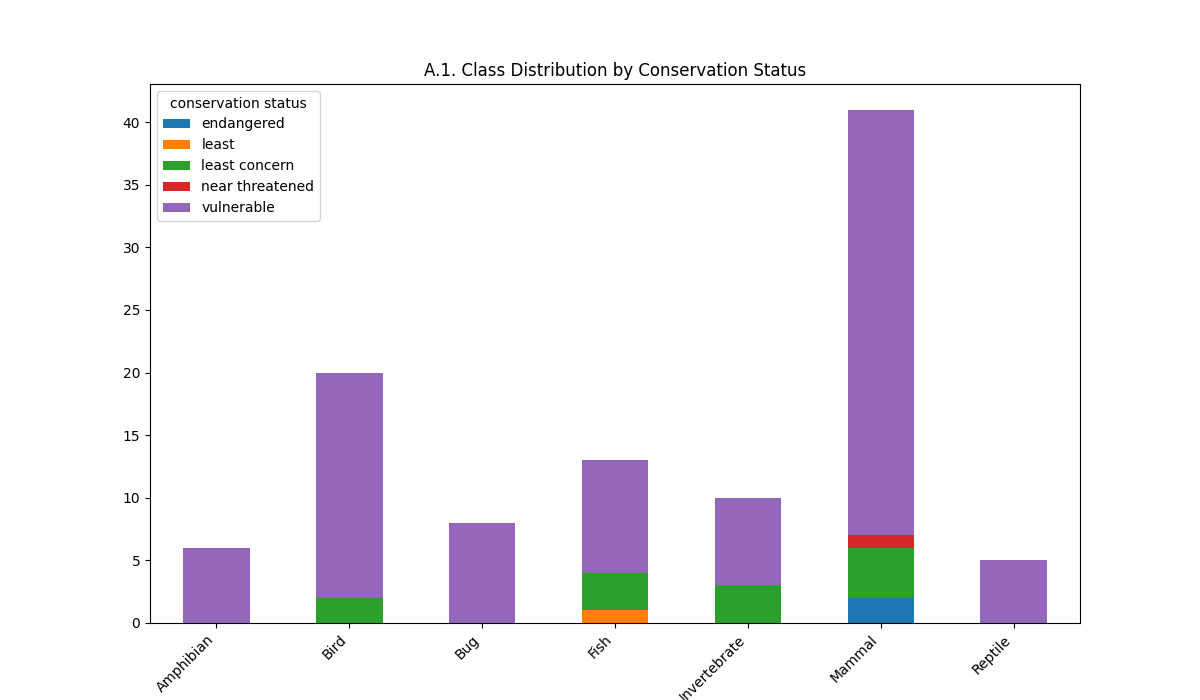


2. Violin Plot: Feature Distribution by Class


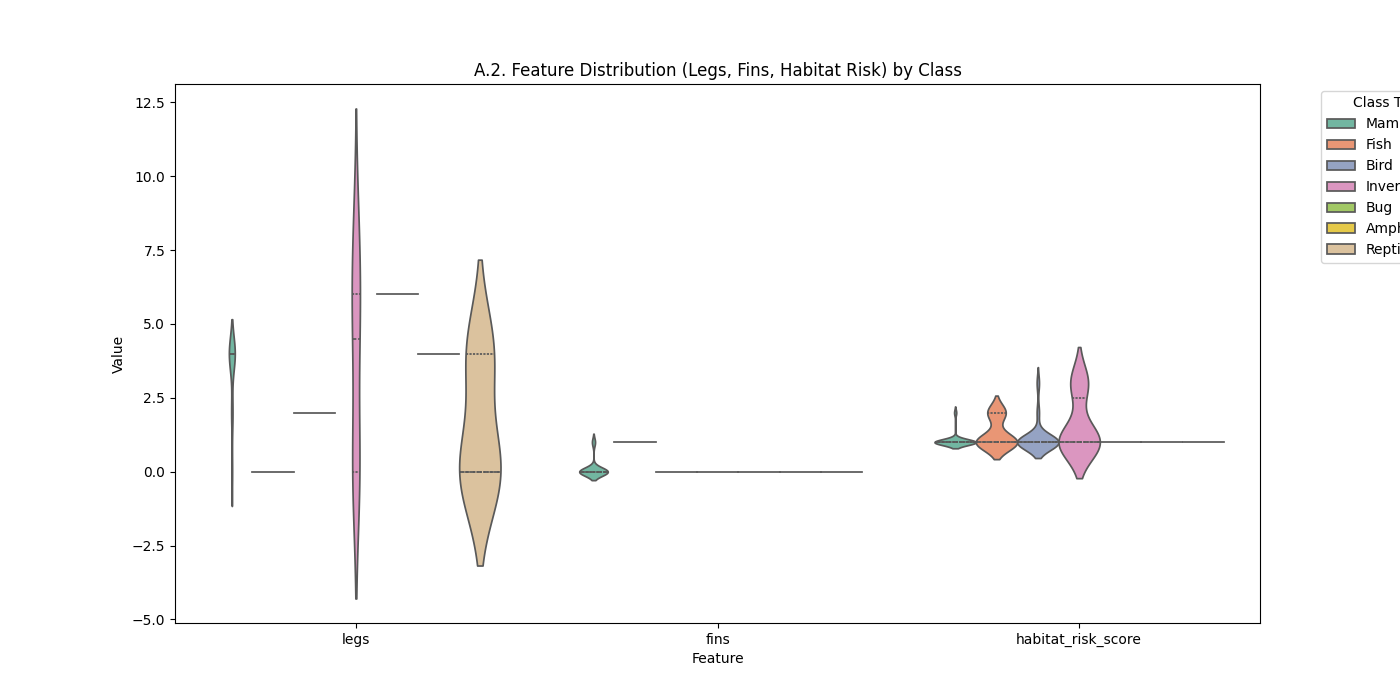


3. Pairplot: Pairwise Relationships Among Key Biological Features


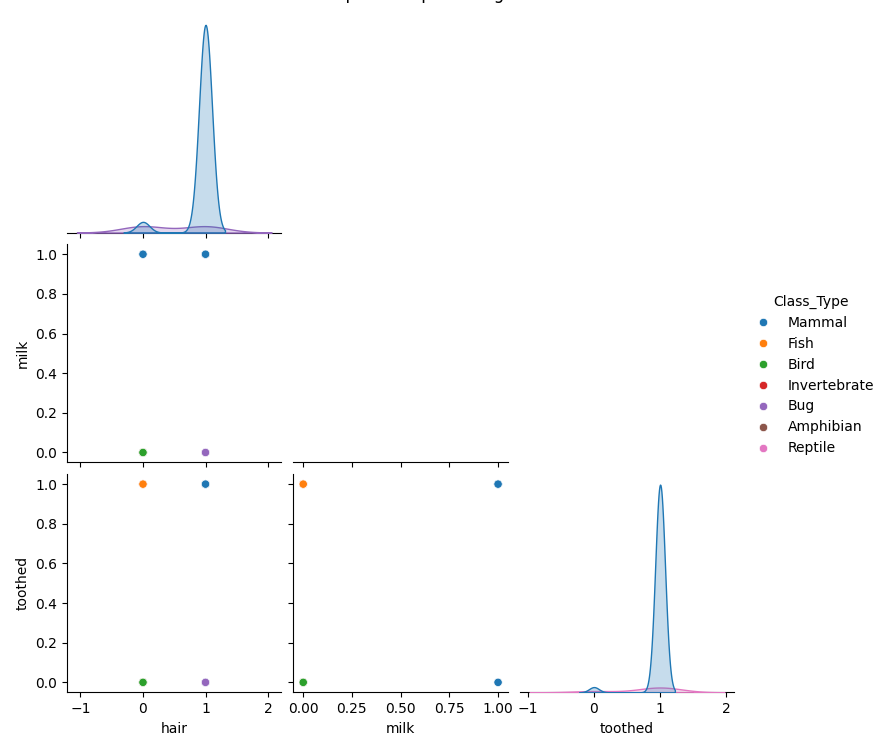


4. Heatmap: Habitat Type vs. Animal Class Distribution


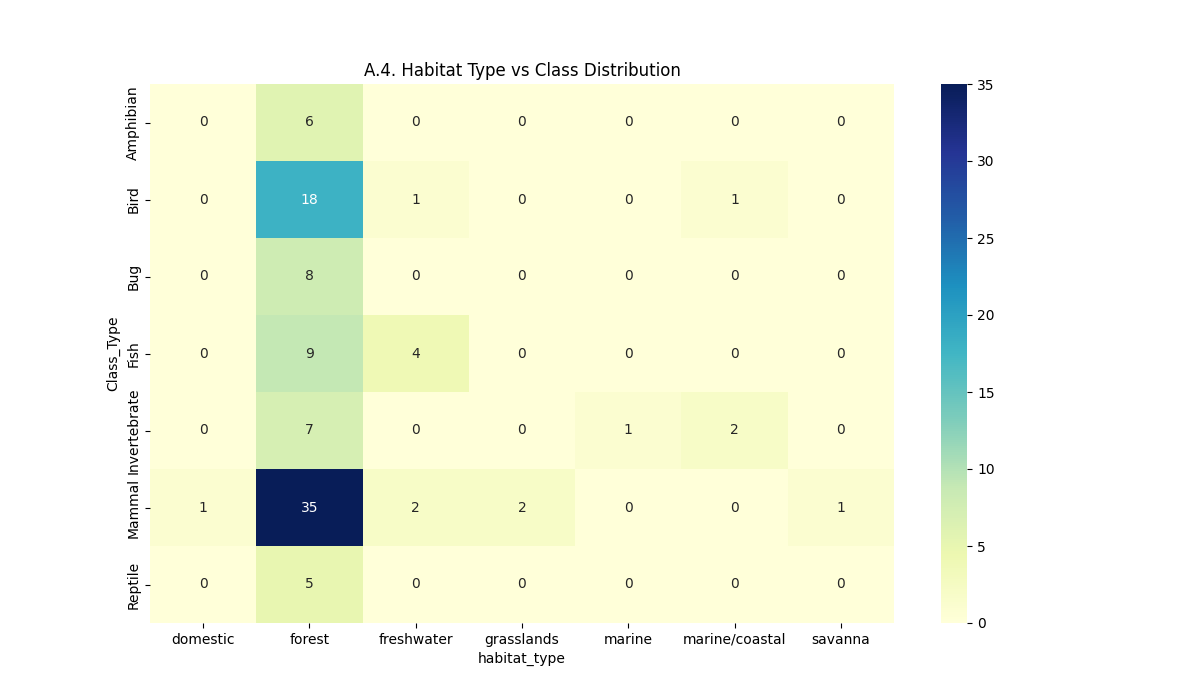

In [26]:
from IPython.display import Image, display

# Task 2 Plots
print("--- Task 2: Exploratory Data Analysis Plots ---")
print("1. Stacked Bar Chart: Class Distribution by Conservation Status")
display(Image(filename='A1_stacked_bar_class_conservation.png'))

print("\n2. Violin Plot: Feature Distribution by Class")
display(Image(filename='A2_violin_feature_dist_by_class.png'))

print("\n3. Pairplot: Pairwise Relationships Among Key Biological Features")
display(Image(filename='A3_pairplot_top3_features.png'))

print("\n4. Heatmap: Habitat Type vs. Animal Class Distribution")
display(Image(filename='A4_heatmap_habitat_class_distribution.png'))




In [27]:
# Task 3 Imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Pandas, NumPy are available from Task 1

# Define Constants needed for this Task (Fixes NameError)
RANDOM_STATE = 42

# METHOD: Beta_train_and_evaluate()
def Beta_train_and_evaluate(self):
    if self.merged_data is None:
        print("Error: Data not loaded. Run Task 1 first.")
        return

    print("\n--- TASK 3: MODEL TRAINING AND EVALUATION ---")

    # --- Prepare Data ---
    X = self.merged_data.drop(columns=['animal_name', 'normalized_name', 'Class_Type',
                                       'Class_Number', 'class_type', 'conservation status',
                                       'habitat_type', 'diet', 'Number_Of_Animal_Species_In_Class'],
                               errors='ignore')
    y = self.merged_data['Class_Number']

    # A. Prepare Data and Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
    )

    # B. Configure & Train Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_split=5, random_state=RANDOM_STATE
    )
    rf_model.fit(X_train, y_train)
    y_train_pred = rf_model.predict(X_train)
    y_test_pred = rf_model.predict(X_test) # Corrected prediction input

    # C. Print Training Performance
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print("\n[C] Random Forest Performance:")
    print(f"Training Accuracy: {train_accuracy : .4f}")
    print(f"Testing Accuracy: {test_accuracy: .4f}")
    print(f"Overfitting Gap: {train_accuracy - test_accuracy : .4f}")

    # D. Classification Report
    report = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)
    print("\n[D] Classification Report:")
    print(classification_report(y_test, y_test_pred, zero_division=0))

    # E. Confusion matrix and HeatMap
    cm = confusion_matrix(y_test, y_test_pred)
    class_mapping = self.merged_data.drop_duplicates(subset=['Class_Number']).set_index('Class_Number')['Class_Type']
    class_labels_sorted = [class_mapping[i] for i in sorted(class_mapping.index)]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels_sorted, yticklabels=class_labels_sorted)
    plt.title(f'E. Random Forest Confusion Matrix (n_estimators=100, max_depth=10)')
    plt.savefig('E_RF_confusion_matrix.png')
    plt.close()
    print("- [E] Confusion Matrix Heatmap saved as E_RF_confusion_matrix.png")

    # F. Feature Importance Plot
    feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
    top_12_features = feature_importances.nlargest(12)
    colors = ['skyblue' if f in self.engineered_feature_names else 'lightcoral' for f in top_12_features.index]
    plt.figure(figsize=(10, 7))
    top_12_features.sort_values(ascending=True).plot(kind='barh', color=colors)
    plt.title('F. Top 12 Feature Importances (Random Forest)')
    plt.savefig('F_feature_importance_plot.png')
    plt.close()
    print("- [F] Feature Importance Plot saved as F_feature_importance_plot.png")

    # G. Train Comparison Model (K-Nearest Neighbors k=5)
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train, y_train)
    y_test_pred_knn = knn_model.predict(X_test)
    knn_accuracy = accuracy_score(y_test, y_test_pred_knn)
    print(f"\n[G] KNN (k=5) Testing Accuracy: {knn_accuracy: .4f}")

    # H. Critical Analysis Output
    f1_scores = {k: v['f1-score'] for k, v in report.items() if k.isdigit()}
    worst_class_num = min(f1_scores, key=f1_scores.get)
    best_class_num = max(f1_scores, key=f1_scores.get)

    top_feature_name = feature_importances.nlargest(1).index[0]
    top_feature_value = feature_importances.nlargest(1).values[0]
    worst_class_name = class_mapping[int(worst_class_num)]
    best_class_name = class_mapping[int(best_class_num)]
    worst_f1 = f1_scores[worst_class_num]
    best_f1 = f1_scores[best_class_num]

    engineered_feature = self.engineered_feature_names[0]
    feature_rank_df = feature_importances.sort_values(ascending=False).reset_index()
    feature_rank_df.columns = ['Feature', 'Importance']
    engineered_feature_rank = feature_rank_df[feature_rank_df['Feature'] == engineered_feature].index[0] + 1

    print ("\n=== MODEL ANALYSIS ===")
    print(f"1. Most important feature: {top_feature_name} (importance : {top_feature_value: .3f})")
    print(f"2. Worst performing class: {worst_class_name} (F1 : {worst_f1:.3f})")
    print(f"3. Best performing class: {best_class_name} (F1: {best_f1:.3f})")
    print(f"4. Your engineered feature '{engineered_feature}' ranked #{engineered_feature_rank}")
    print(f"5. Model comparison : KNN = {knn_accuracy:.3f} vs RF={test_accuracy:.3f}")


# Add the method to the class dynamically and run Task 3
DataIntegrator.Beta_train_and_evaluate = Beta_train_and_evaluate
processor.Beta_train_and_evaluate()


--- TASK 3: MODEL TRAINING AND EVALUATION ---

[C] Random Forest Performance:
Training Accuracy:  1.0000
Testing Accuracy:  0.9677
Overfitting Gap:  0.0323

[D] Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         6
           3       1.00      0.50      0.67         2
           4       0.80      1.00      0.89         4
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         3

    accuracy                           0.97        31
   macro avg       0.97      0.93      0.94        31
weighted avg       0.97      0.97      0.96        31

- [E] Confusion Matrix Heatmap saved as E_RF_confusion_matrix.png
- [F] Feature Importance Plot saved as F_feature_importance_plot.png

[G] KNN (k=5) Testing Accuracy:  0.8710

=== MODEL ANALYSIS ===
1. Most important 


--- Task 3: Model Evaluation Plots ---
5. Confusion Matrix Heatmap


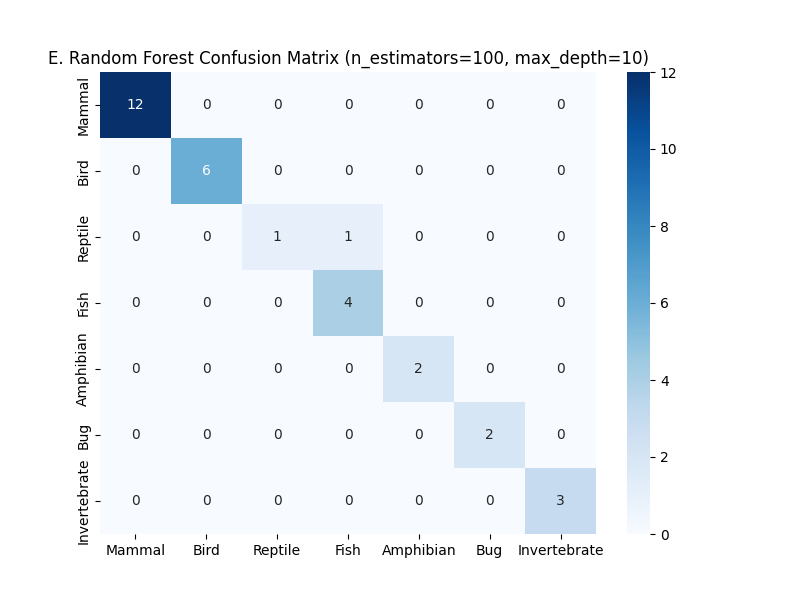


6. Feature Importance Plot


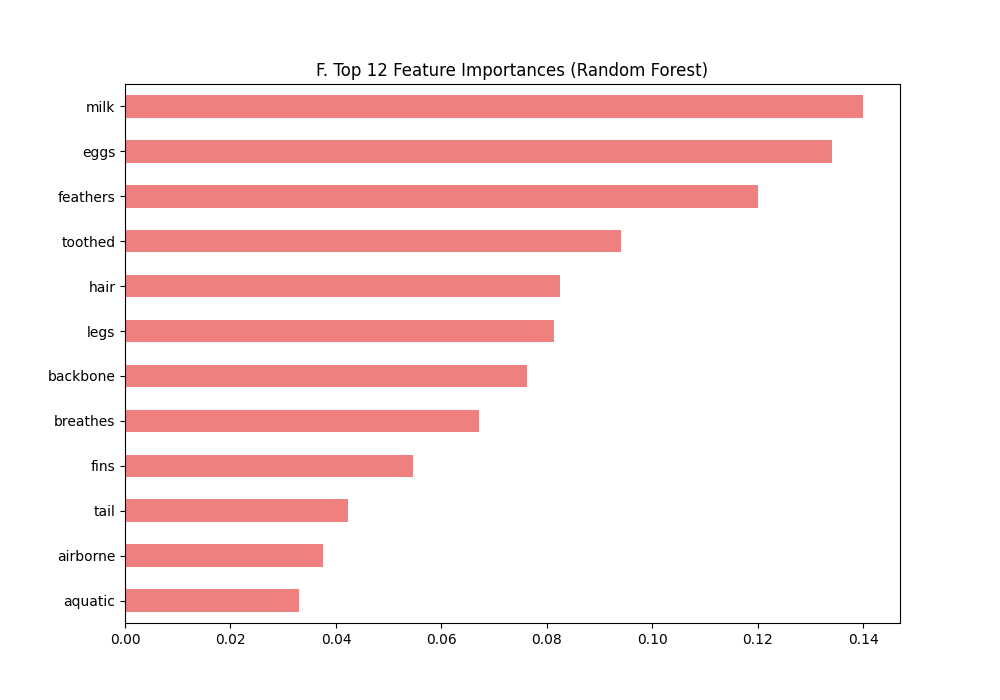

In [28]:

# Task 3 Plots
print("\n--- Task 3: Model Evaluation Plots ---")
print("5. Confusion Matrix Heatmap")
display(Image(filename='E_RF_confusion_matrix.png'))

print("\n6. Feature Importance Plot")
display(Image(filename='F_feature_importance_plot.png'))